# TL;DR

Most redditors only comment on one subreddit a month while a few redditors comment on hundreds. I'm a social scientist who is trying to figure out why and I want your ideas so that I can test them. 


# A puzzle about redittors

[I'm a researcher](https://jeremydfoote.com/) who is interested in understanding how people decide which things to contribute to and participate in, especially online.

I have a puzzle about redditors (and participants in other systems) that I think is perplexing and that I would love your help in figuring out.

To see why it's so perplexing, though, it's worth taking a slight detour.


## First, a word about distributions

We have all heard of the normal distribution or bell curve. When an outome is the result of a bunch of random, uncorrelated processes, we see normal distributions.

For example, the following code simulates the height of 500 people, assuming that people's height is the linear combination of five genes plus their diet as a child.

The result is a classic normal distribution.


In [108]:
library(tidyverse); # First load the tidyverse for visualizing and manipulating data
theme_set(theme_minimal())

In [4]:
n = 500 # How many people we are simulating
gene_a = sample(c(0,1,2), size = n, replace = T) # Each gene can be 0, 1, or 2
gene_b = sample(c(0,1,2), n, replace = T)
gene_c = sample(c(0,1,2), n, replace = T)
gene_d = sample(c(0,1,2), n, replace = T)
gene_e = sample(c(0,1,2), n, replace = T)
nutrition = runif(100, min=0,max=2) # Nutrition is also from 0 to 2
height = gene_a + gene_b + gene_c + gene_d + gene_e + nutrition # Height is a linear combination of each gene plus nutrition

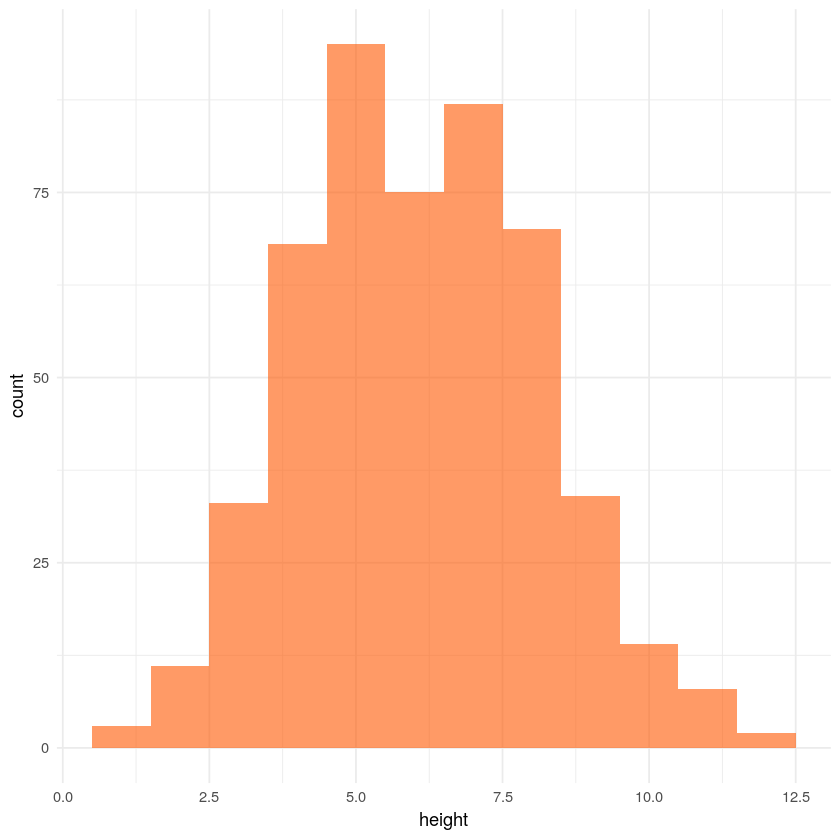

In [37]:
as.data.frame(height) %>% ggplot() + geom_histogram(aes(x=height), binwidth = 1, fill = '#FF5700', alpha=.6)

## Heavy-tailed distributions

Normal distributions are very common in nature, because these sorts of independent random processes are common.

However, there is another sort of distribution which also appears often. It goes by a number of names which refer to the same basic idea (e.g., power-law, scale-free, Zipf's law, long-tailed distributions, and Pareto distributions). These distributions look like this:

In [122]:
reddit_data = read_csv('~/Desktop//DeleteMe/reddit_comments_groupby_author_subreddit_201701.csv', col_types = c(col_character(), col_character(), col_integer()))
users_per_sr_sample = reddit_data %>% group_by(subreddit) %>% summarize(contributors = n()) %>% sample_n(10000)
sr_per_user_sample = reddit_data %>% group_by(author) %>% summarize(subreddits = n()) %>% sample_n(10000)

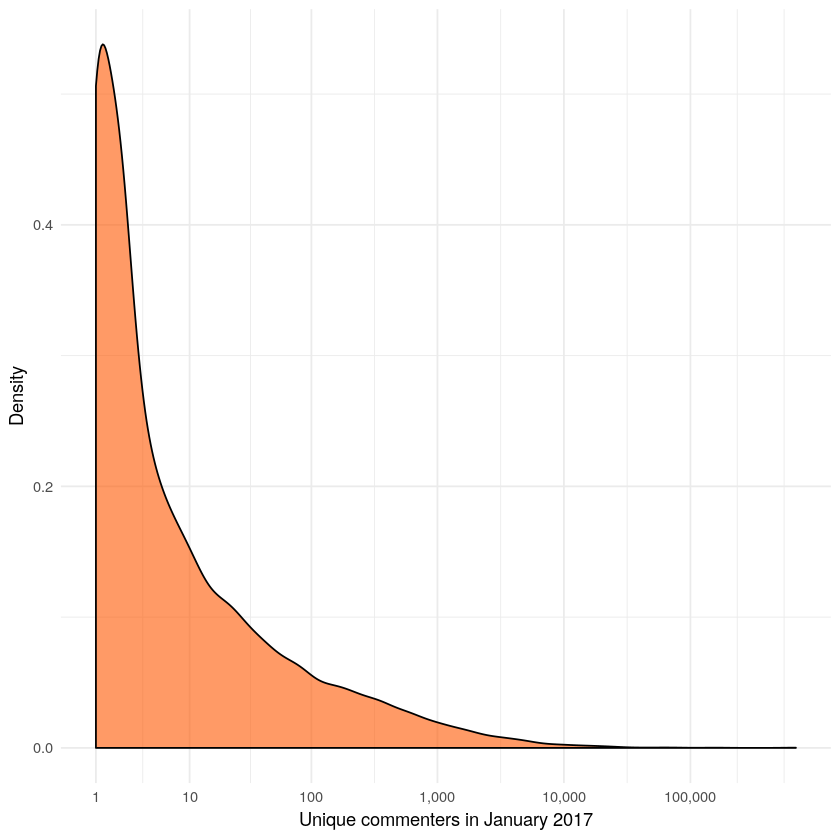

In [156]:
users_per_sr_sample %>% #filter(contributors > 100 & contributors <= 10000) %>% 
ggplot() + 
    geom_density(aes(x=contributors), fill = '#FF5700', alpha=.6) + 
    #scale_y_continuous(trans = 'log1p', breaks=10^(0:5), labels = comma) +
    scale_x_continuous(trans = 'log1p', breaks=10^(0:5), labels = comma) +
    xlab('Unique commenters in January 2017') + ylab('Density')

The plot above is the number of commenters to a sample of 10,000 subreddits on reddit in January 2017. Note that the x axis is logged, so while the vast majority of subreddits have only a few commenters, a few subreddits have tens or hundreds of thousands of commenters. Another way of visualizing what's going on is to order the subreddits by their size and plot them all in order. Again, it's clear that a few subreddits are getting the majority of attention with a steep, predictable decline in attention.

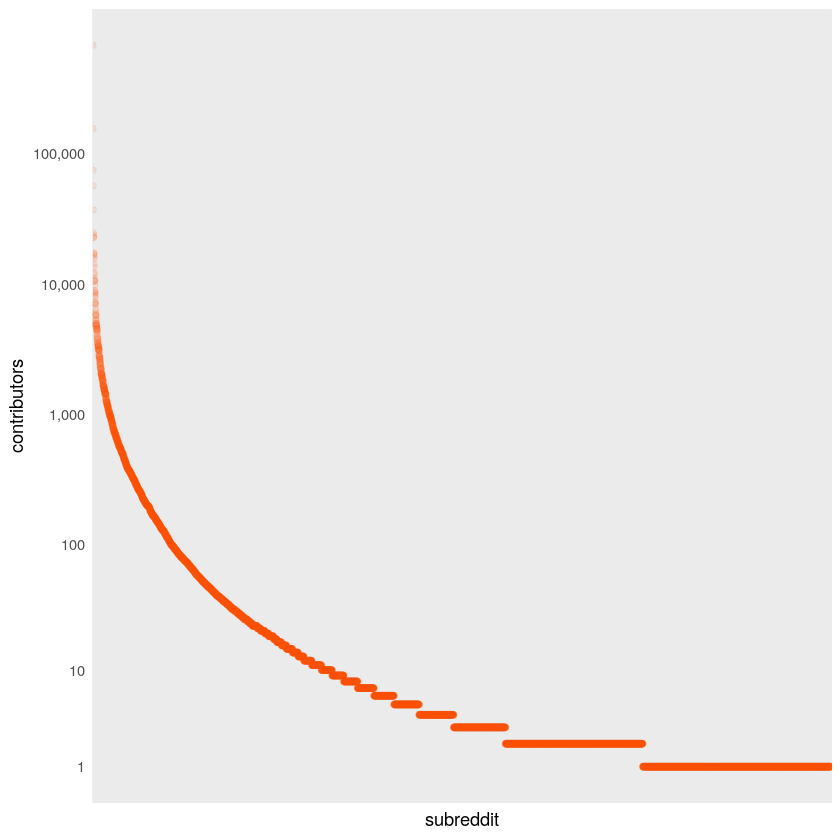

In [157]:
users_per_sr_sample %>% 
    arrange(-contributors) %>% 
    mutate(subreddit=factor(subreddit, 
                            levels=subreddit)) %>% 
ggplot() +
    geom_point(aes(x=subreddit, y=contributors), color = '#FF5700', alpha=.1) + theme(axis.ticks.x=element_blank(),
                                                    axis.text.x = element_blank()) + 
    scale_y_continuous(trans = 'log1p', breaks=10^(0:5), labels = comma)

### Where do heavy-tailed distributions come from?
These heavy-tailed distributions are surprisingly common. The number of links to a page, the sizes of cities, the rate at which words are used in books, and the size of moon craters and solar flares all follow heavy-tailed distributions. Unlike normal distributions, where the mechanisms behind them are well-understood, heavy-tailed distributions are trickier. There's a [great YouTube video](https://www.youtube.com`/watch?v=skvnj67YGmw) on the topic.

There are a few processes/mechanisms that can produce these sorts of distributions. One is called the [Matthew Effect](https://en.wikipedia.org/wiki/Matthew_effect) or "cumulative advantage". The name comes from a parable in the Bible, where Jesus taught, "For to every one who has will more be given, and he will have abundance; but from him who has not, even what he has will be taken away."

The idea is that there are advantages that come to already-popular things. For example, a web page that is already highly linked to will be more likely to be discovered and therefore more likely to be linked to again than a similar page.

This mechanism seems reasonable for subreddits - popular subreddits receive more posts, are more likely to appear on r/all, etc.

### The subreddits per user puzzle

However, the number of contributors per subreddit isn't the only place we see a heavy-tailed distribution. This is a plot of subreddits per commenter:

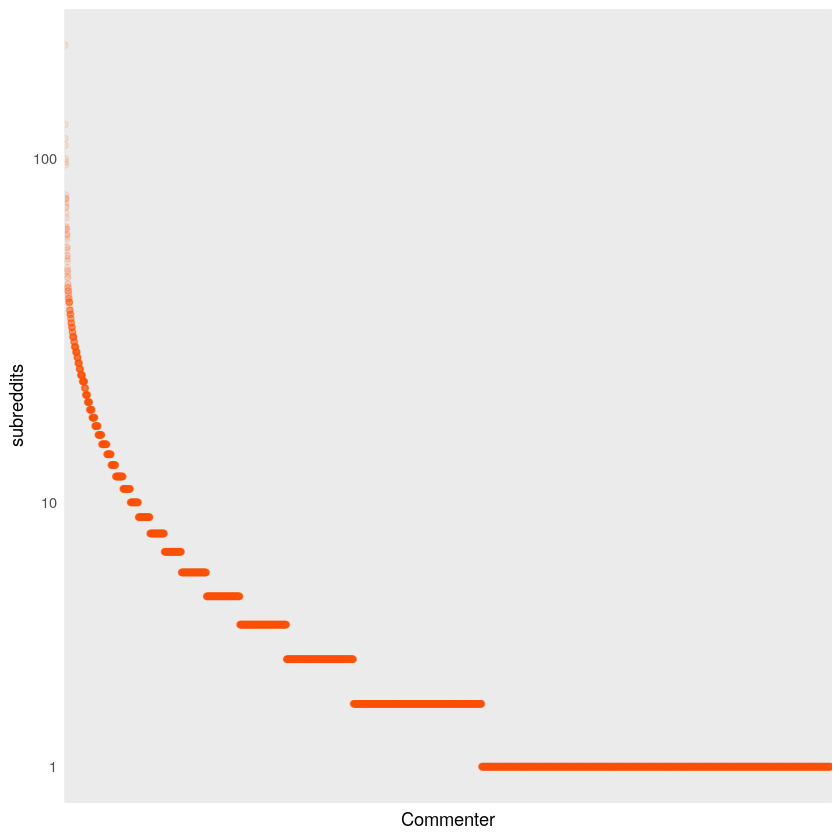

In [50]:
sr_per_user_sample %>% filter(author != '[deleted]') %>%
    arrange(-subreddits) %>% 
    mutate(author=factor(author, 
                            levels=author)) %>% 
ggplot() +
    geom_point(aes(x=author, y=subreddits), color = '#FF5700', alpha=.1) + theme(axis.ticks.x=element_blank(),
                                                    axis.text.x = element_blank()) + 
    scale_y_continuous(trans = 'log1p', breaks=10^(0:5), labels = comma) + xlab('Commenter')

And here it is as a log-log plot:

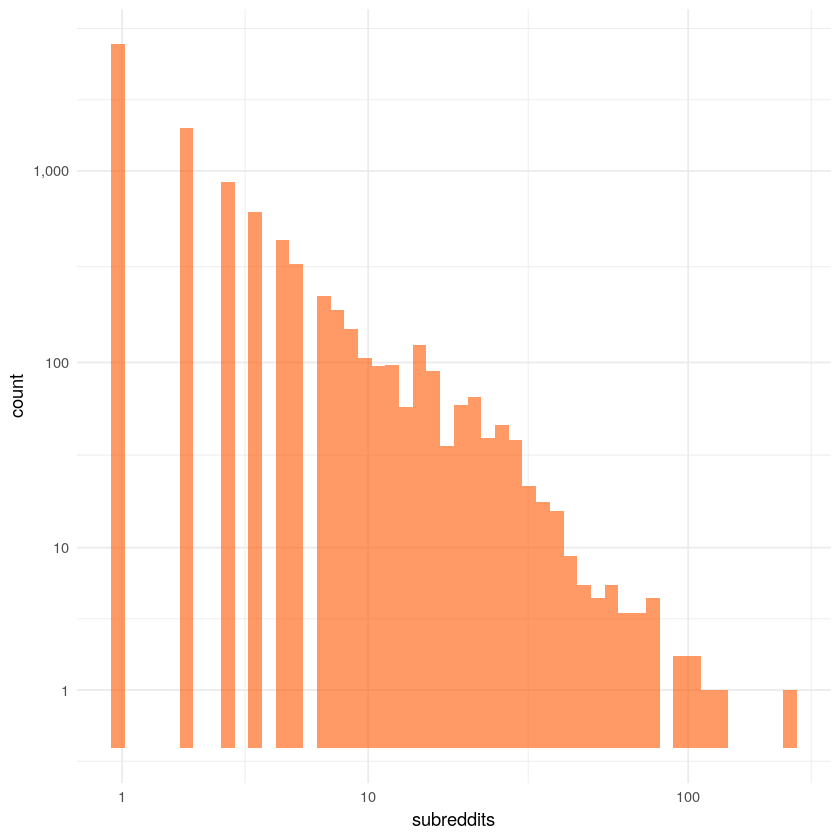

In [47]:
sr_per_user_sample %>%
ggplot() + 
    geom_histogram(aes(x=subreddits), fill = '#FF5700', alpha=.6, bins=50) + 
    scale_y_continuous(trans = 'log1p', breaks=10^(0:4), labels = comma) + 
    scale_x_continuous(trans = 'log1p', breaks=10^(0:3), labels = comma)

It seems unlikely that the Matthew effect can explain what is going on here. Why would people who already participate in many subreddits be likely to participate in even more?

### A possible solution?

There is another mechanism that produces skewed distributions. If I flip a coin and count how many heads in a row I get before getting tails, we see an exponential distribution (technically a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution) which gets us most of the way there.

In [110]:
get_x <- function(p){
    x = 0 # Start at 0
    keep_going = TRUE
    while(keep_going == TRUE){
        if(runif(1) < p){ # Pick a random number between 0 and 1; if it's less than p, then add one to x and keep going
            x = x + 1
        }
        else{ # Otherwise, quit
            return(x)
        }
    }
}
result = replicate(10000, get_x(.3))

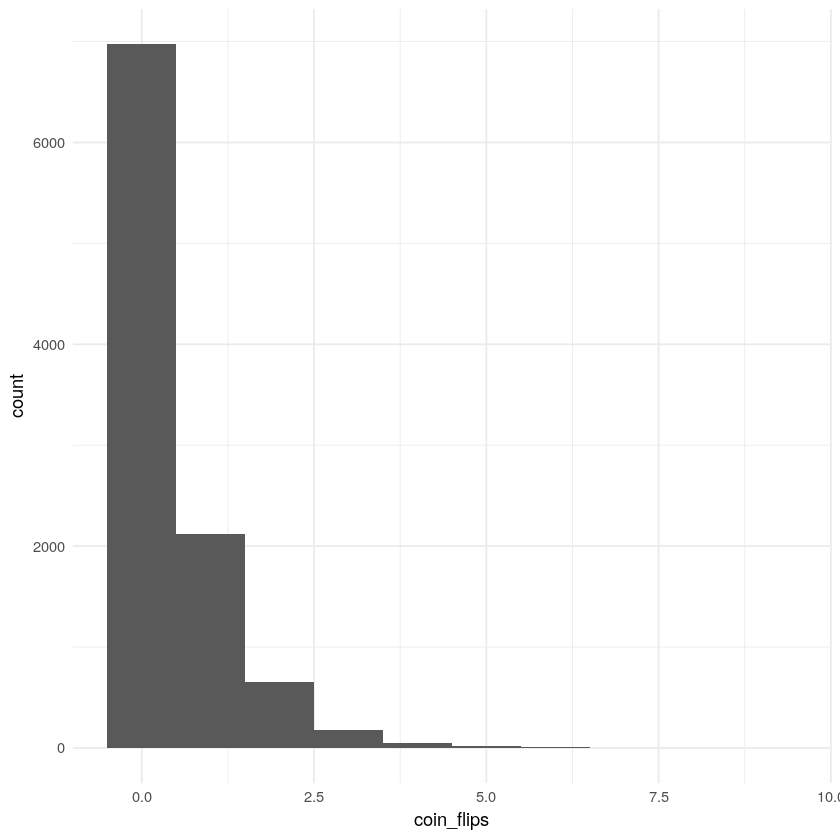

In [111]:
data.frame(coin_flips = result) %>% ggplot(aes(x=coin_flips)) + geom_histogram(binwidth = 1)

## And yet....

Are there mechanisms that look like this on reddit? Maybe if you choose to comment on one subreddit that puts you in the commenting mood and you comment on another until you finally aren't in the mood? That feels a bit far-fetched but maybe not?

Indeed, when we look at how many communities people contributed to in January compared to February, there is about as clear a relationship as we get in the social sciences. People who participated in many communities in January contributed to many in February. Unsurprisingly, it isn't as simple as our naive coin flip model.

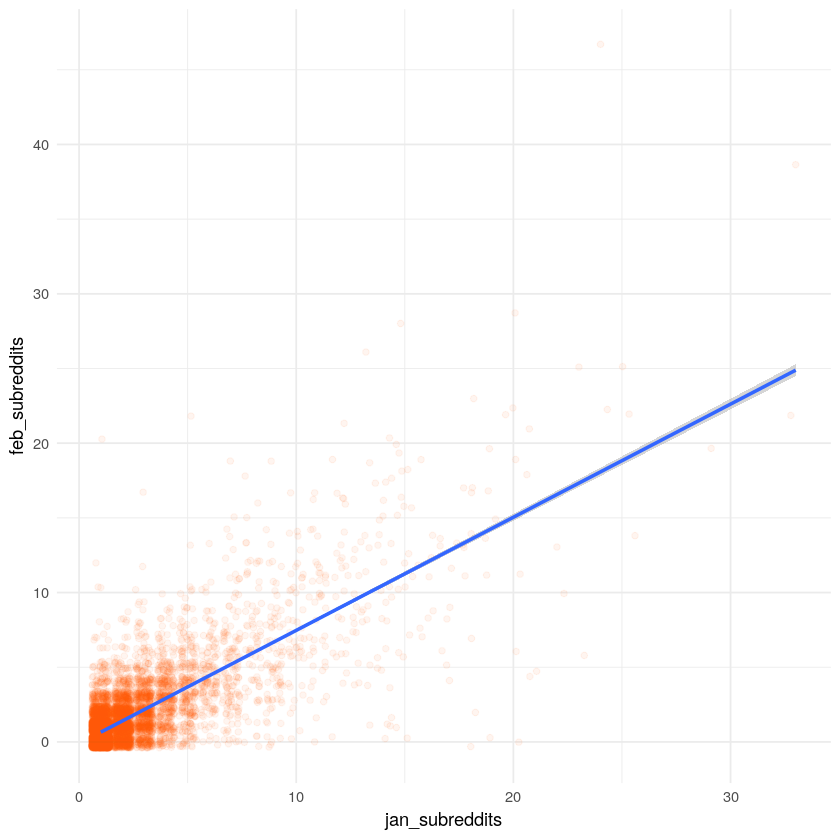

In [165]:
# Load the data
jan_feb_sample = read_csv('~/Desktop//DeleteMe//sr_jan_feb_sample.csv', col_types = c(col_character(), col_integer(), col_integer()))

jan_feb_sample %>% 
ggplot(aes(x=jan_subreddits, y=jan_subreddits + delta)) + 
    geom_jitter(alpha=.06, color = '#FF5700') + 
    geom_smooth(method='lm') +
    ylab('feb_subreddits')

## A plea for help

So what is going on? If it isn't Matthew effects and it isn't a coin flip then what is happening? 

**What are some mechansims that you think might influence some people to comment on dozens or even hundreds of subreddits while the vast majority only comment on one?**

Give me ideas on the reddit post or via [reddit mail](https://www.reddit.com/user/jdfoote) or <a href="mailto:jdfoote@u.northwestern.edu">email</a> and I will keep doing data analsyis and simulations to see if we can figure out what's going on.

# Appendix

## It isn't bots

These are the top users in the sample and none of them appear to be bots.

In [166]:
sr_per_user_sample %>% arrange(-subreddits) %>% head(20)

author,subreddits
onbeschrijfelijkheid,109
MrHorseHead,100
octopusdixiecups,94
LtVaginalDischarge,90
Plasmabat,80
Einsteins_coffee_mug,75
ryeshoes,75
PM_ME_UR_FLOWERS,72
Jaredlong,70
retrobuddha,69


## Cumulative advantage simulation

For those interested in how the cumulative advantage / preferential attachment model works, here's a very simple simulation

In [82]:
# Initialize a list of commenters per subreddit
subreddit_commenters = rep(0,1000)

# Function for choosing a subreddit to comment on
choose_subreddit <- function() {
    # Get the index of the subreddit; the probability of any given subreddit being chosen is based on its current size.
    # It can't just be current_size / total of all subreddits, or subreddits with 0 commenters would never be chosen.
    # So, we add 1 to each subreddit, then make the probability current_size / total_size of all subreddits 
    i = sample(1:length(subreddit_commenters), 1, prob=(subreddit_commenters + 1)/sum(subreddit_commenters + 1))
    return(i)
    }

# Perform the function a bunch of times

for (x in 1:5000){
    i = choose_subreddit()
    subreddit_commenters[i] = subreddit_commenters[i] + 1
}

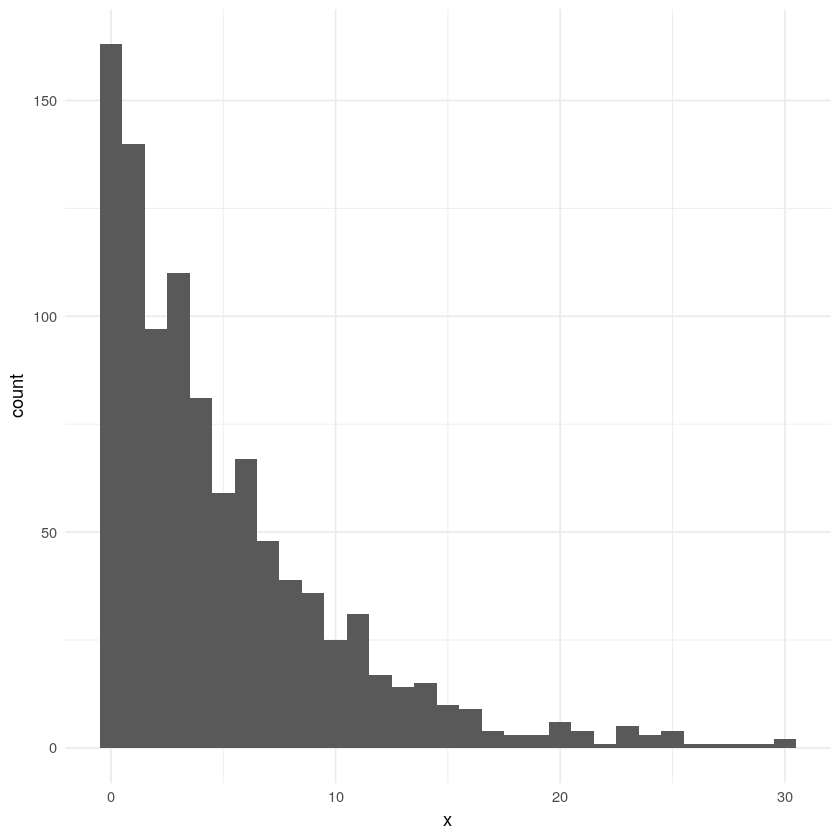

In [107]:
data.frame(x = subreddit_commenters) %>% ggplot(aes(x=x)) + geom_histogram(binwidth = 1)